# Emulator training

In [1]:
import tensorflow as tf
from tf.keras.models import Sequential
from tf.keras.layers import Dense
from tf.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import pandas as pd
import numpy as np
from datetime import datetime
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import corner
from astropy.io import ascii

## Load GPU

In [3]:

gpus = tf.config.experimental.list_physical_devices('GPU')

In [4]:
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])
    except RuntimeError as e:
        print(e)

# Set our file locations and column names

In [5]:
SPECTRA_DIR = '/home/afullard/storage/slip_array'
SPECTRA_DIR2 = '/home/afullard/storage/slip_array_1000'

PARAM_TABLE = "/home/afullard/storage/slip_array/sample_space.csv"
PARAM_TABLE2 = "/home/afullard/storage/slip_array_1000/sample_space.csv"

# Names of the parameter columns in order
columns = ['nsrc', 'nsrc2', 'taumax0', 'ellipse_c']

In [6]:
def load_param_table(param_table):
    # Load up a table of parameters
    
    parameters_raw_table = pd.read_csv(param_table)
    del parameters_raw_table['geom']
    del parameters_raw_table['q']
    del parameters_raw_table['nsrc2']
    del parameters_raw_table['Unnamed: 0']
    
    return parameters_raw_table

In [76]:
parameters_raw = load_param_table(PARAM_TABLE)
parameters_raw_1000 = load_param_table(PARAM_TABLE2)

## Plot histograms of parameters

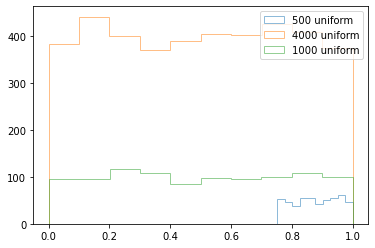

In [8]:
plt.hist(parameters_raw['taumax0'], alpha=0.5, label = "4000 uniform", histtype = 'step')
plt.hist(parameters_raw_1000['taumax0'], alpha=0.5, label = "1000 uniform", histtype = 'step')
plt.legend()

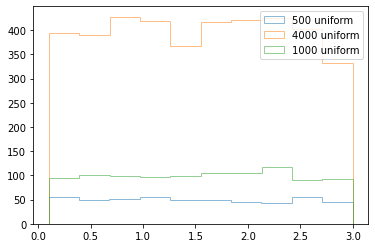

In [9]:
plt.hist(parameters_raw['ellipse_c'], alpha=0.5, label = "4000 uniform", histtype = 'step')
plt.hist(parameters_raw_1000['ellipse_c'], alpha=0.5, label = "1000 uniform", histtype = 'step')
plt.legend()

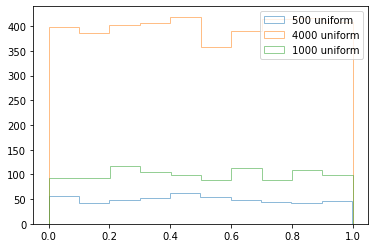

In [10]:
plt.hist(parameters_raw['nsrc'], alpha=0.5, label = "4000 uniform", histtype = 'step')
plt.hist(parameters_raw_1000['nsrc'], alpha=0.5, label = "1000 uniform", histtype = 'step')
plt.legend()

# Load phase curves

Note the change required to train the Stokes U emulator

In [11]:
def choose_value(table, colname, i):
    return table[np.where(table[colname] == i)]

def read_models(params, directory, modifier=0):
    all_data = []
    
    full_params_rows = []
    
    i=0+modifier
    for index, row in params.iterrows():
        folder = directory+'/slip_'+str(index)
        try:
            finites = ascii.read(folder + "/finites.out", data_start=3, delimiter=" ", names=["cosi", "Phi", "lam", "I", "q", "u", "v"])
        except:
            print("Test" + str(index) + " didn't produce output!")
            params.drop(index, inplace=True)
            i+=1
            continue

        cosines = finites['cosi'].data[:90]
        for value in cosines:
            phased_data = choose_value(finites, 'cosi', value)
            phased_Q = phased_data['q'].data
            phased_U = phased_data['u'].data
            new_row = row.copy()
            new_row['i'] = value
            full_params_rows.append(new_row)
            # CHANGE THIS LINE TO TRAIN ON STOKES U
            all_data.append(phased_Q)
            
        i+=1
    
    new_params = pd.DataFrame(full_params_rows)
    
    return all_data, new_params

In [ ]:
data, parameters_raw = read_models(parameters_raw, SPECTRA_DIR)
data_1000, parameters_raw_1000 = read_models(parameters_raw_1000, SPECTRA_DIR2)

Test7 didn't produce output!
Test8 didn't produce output!
Test9 didn't produce output!


## Set up data and parameters for the emulator

In [ ]:
parameters_raw_full = pd.concat([parameters_raw, parameters_raw_1000])
parameters_raw_full.reset_index(drop=True,inplace=True)
data_4000_ndarray = np.stack(data)
data_1000_ndarray = np.stack(data_1000)
all_data_numpy = np.concatenate((data_4000_ndarray, data_1000_ndarray))

In [ ]:
scaler_data = StandardScaler()
scaler_parameters = StandardScaler()

all_data_norm = scaler_data.fit_transform(all_data_numpy)
parameters_norm = scaler_parameters.fit_transform(parameters_raw_full)

# Train the emulator

In [ ]:
# Split the data into test, train, and validation

X_train, X_test, y_train, y_test = train_test_split(parameters_norm, all_data_norm, test_size=0.1)

## Emulator architecture

In [ ]:
model = Sequential()
model.add(Dense(30, input_dim=4, activation='softplus', kernel_initializer='glorot_normal'))
for _ in range(0,3):
    model.add(Dense(30, activation='softplus', kernel_initializer='glorot_normal'))
model.add(Dense(y_train.shape[1], kernel_initializer='glorot_normal'))

model.compile(loss='mean_squared_error', optimizer='Nadam')

## Training setup

In [ ]:
cur_date_str = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
logdir="logs/scalars/" + cur_date_str
tensorboard_callback = TensorBoard(log_dir=logdir)
checkpoints_dir = os.path.join('checkpoints', cur_date_str)
os.makedirs(checkpoints_dir, exist_ok=True)

checkpointer_best = ModelCheckpoint(monitor='val_loss', filepath=os.path.join(checkpoints_dir, 'grid_log_uniform_weights_best.h5'), 
                                    save_best_only=True, save_weights_only=True)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=500, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20000, batch_size = 256,
          callbacks=[checkpointer_best, tensorboard_callback], verbose=0)

## Save model

Note: change name for Stokes u

In [ ]:
tf.saved_model.save(model, "prelim_model_q")

## Dump scalers for parameters and data

In [ ]:
from pickle import dump

dump(scaler_parameters, open('scaler_parameters_q.pkl', 'wb'))
dump(scaler_data, open('scaler_data_q.pkl', 'wb'))

# Plot results

[-0.81723019 -0.15181653  0.96152792  0.81116376]
[ 0.69222447 -0.78490788  0.10400768 -0.88999194]
[-0.14873203 -0.39852864 -1.73257375  1.23689817]
[ 1.70713506e+00 -8.78892382e-01 -6.40457581e-04 -1.38823300e+00]
[ 1.03936211 -1.55314741 -0.89666334 -0.96449264]
Worst match 40224
[0.087619  0.4166308 2.5254707 0.99985  ]
[ 6.33008676e-01  5.54583337e-05  6.94089118e-01 -4.84810000e-01]
Worst
[0.57816326 0.81502378 1.79773845 0.99985   ]
Worst
[0.087619  0.4166308 2.5254707 0.98769  ]
Worst
[ 0.98947417  0.81377292  2.92515282 -0.99985   ]
Worst
[0.82974231 0.99263913 2.44219893 0.99985   ]
Worst
[0.087619  0.4166308 2.5254707 0.99985  ]


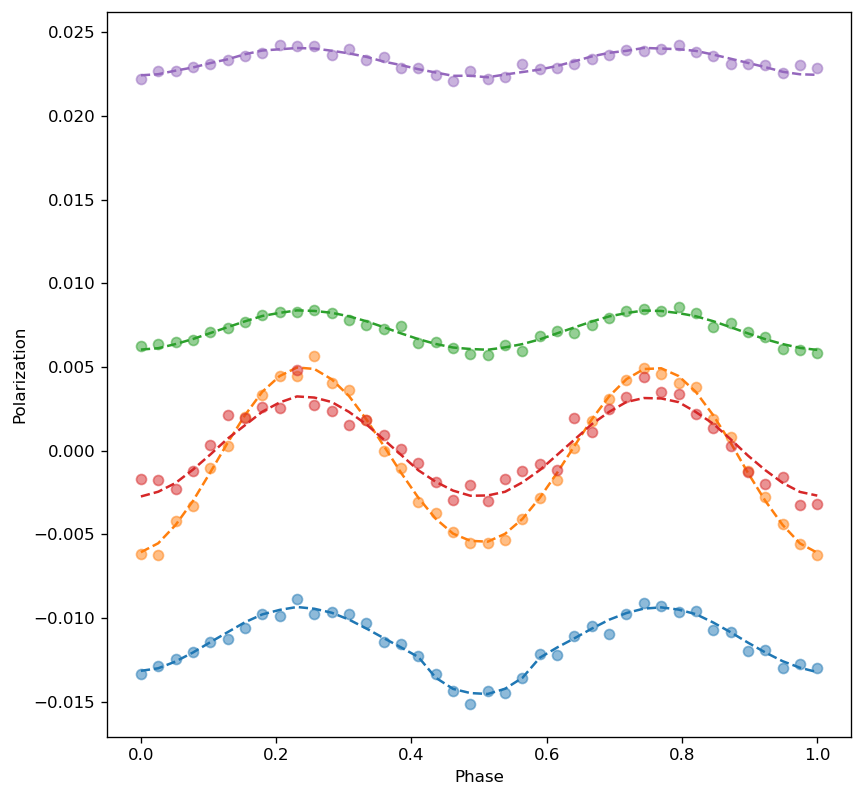

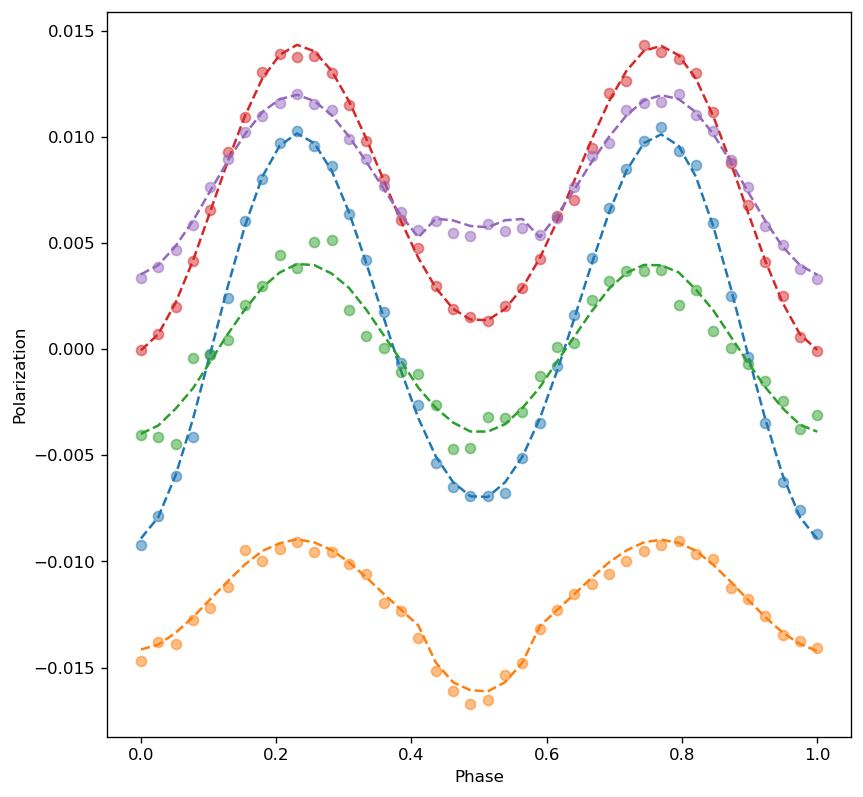

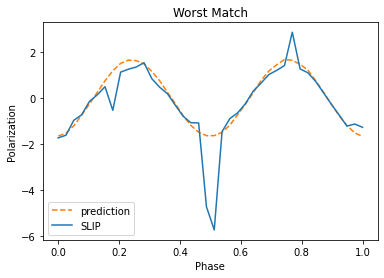

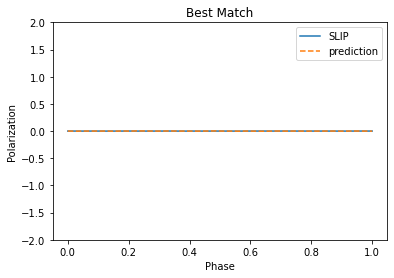

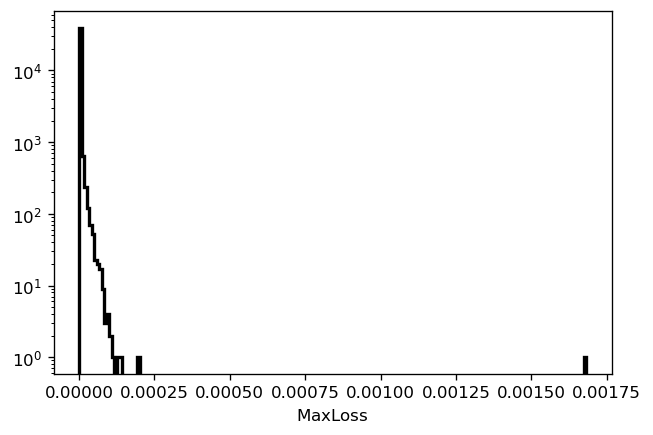

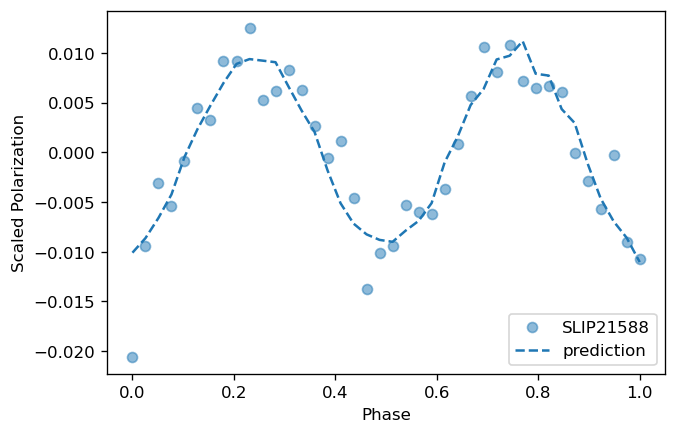

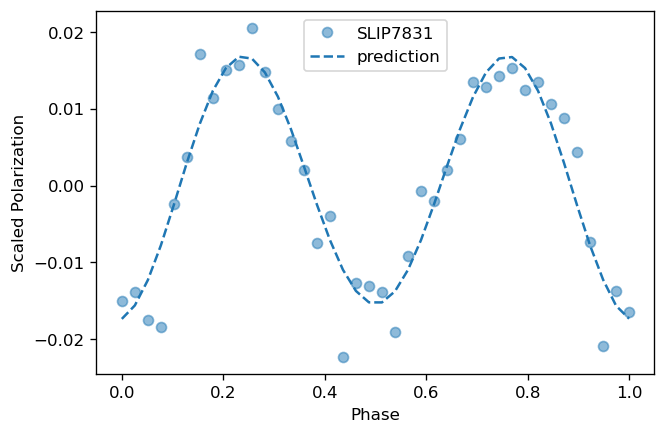

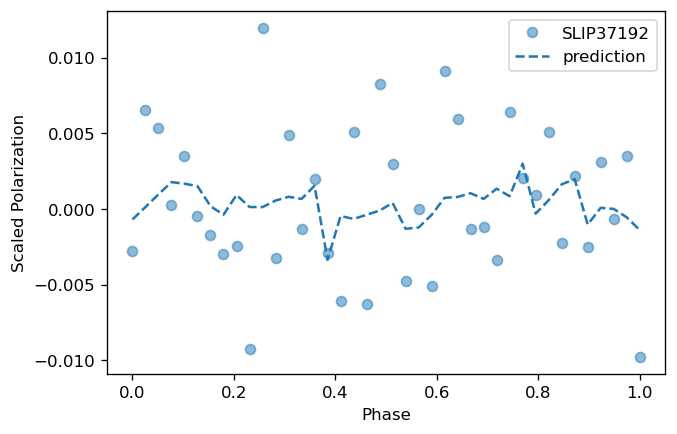

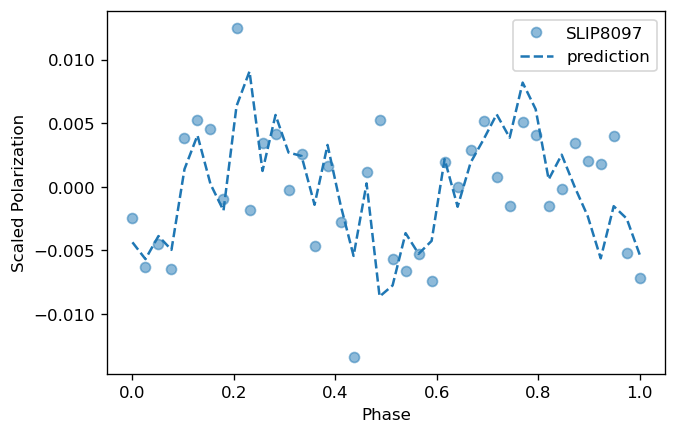

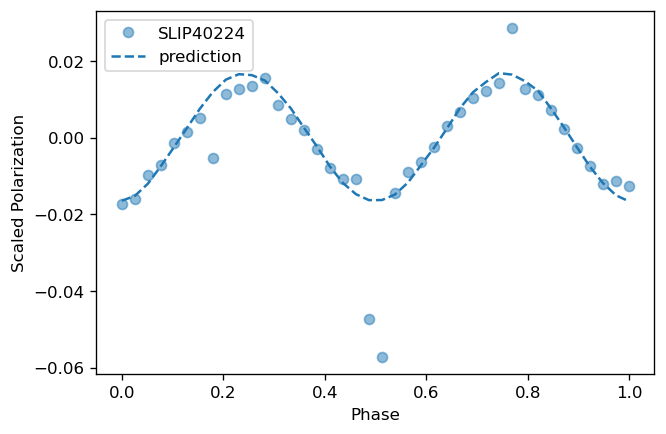

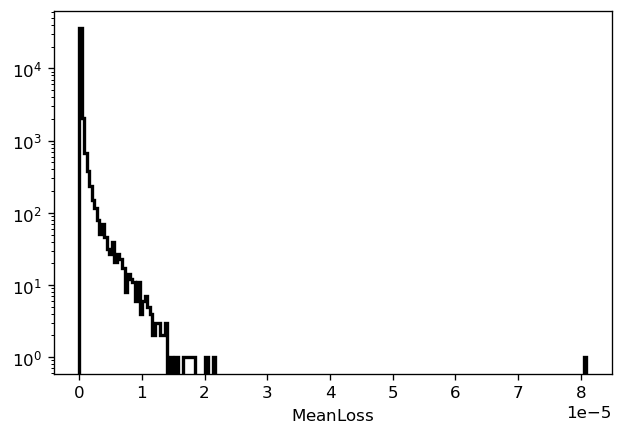

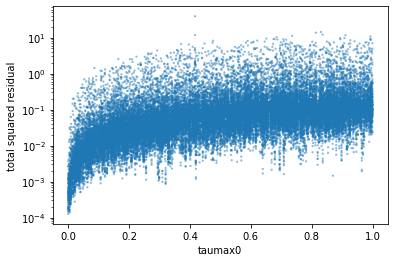

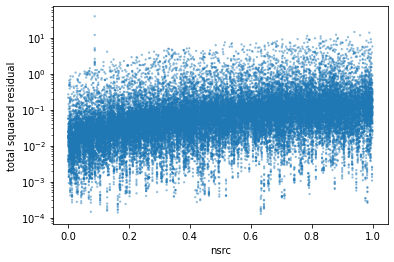

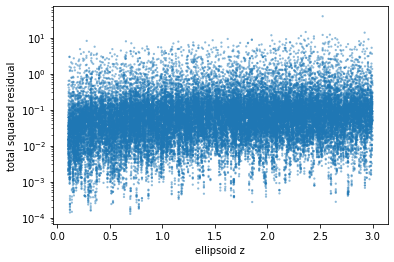

In [121]:
%matplotlib inline

plt.figure(dpi=120, figsize=(8,8))
test_idx = [234, 145, 45, 23]

predictions_raw = model.predict(X_test).astype(np.float64)
y_test_raw=y_test

params_normed = scaler_parameters.inverse_transform(X_test)

predictions_normed = scaler_data.inverse_transform(predictions_raw)
y_test_normed = scaler_data.inverse_transform(y_test_raw)

wave = np.linspace(0.0, 2*np.pi, num=40) / (2*np.pi)

for j, idx in enumerate(np.random.randint(0, len(params_normed), 5)):
    print(X_train[idx])
    line, = plt.plot(wave, y_test_normed[idx], 'o', label='SLIP'+str(idx), alpha=0.5)
    plt.plot(wave, predictions_normed[idx], label='prediction', ls='--', color=line.get_color())
plt.xlabel(r'Phase')
plt.ylabel(r'Polarization')

plt.figure(dpi=120, figsize=(8,8))

for j, idx in enumerate(np.random.randint(0, len(params_normed), 5)):
    line, = plt.plot(wave, y_test_normed[idx], 'o', label='SLIP'+str(idx), alpha=0.5)
    plt.plot(wave, predictions_normed[idx], label='prediction', ls='--', color=line.get_color())
plt.xlabel(r'Phase')
plt.ylabel(r'Polarization')

loss = ((predictions_raw - y_test_raw)**2).sum(axis=1)

test_idx = np.argsort(loss)[::-1][:10]
idx = np.argmax(loss)

print("Worst match", idx)
print(params_normed[idx])

fig, ax = plt.subplots(1,1)
plt.errorbar(wave, y_test_normed[idx]*100, label='SLIP')
plt.plot(wave, predictions_normed[idx]*100, label='prediction', ls='--')
ax.set_title("Worst Match")
ax.set_xlabel(r'Phase')
ax.set_ylabel(r'Polarization')
ax.legend()

np.random.seed(2508)
idx = np.argmin(loss)

print(params_normed[idx])

fig, ax = plt.subplots(1,1)
plt.plot(wave, y_test_normed[idx]*100, label='SLIP')
plt.plot(wave, predictions_normed[idx]*100, label='prediction', ls='--')
ax.set_title("Best Match")
ax.set_xlabel(r'Phase')
ax.set_ylabel(r'Polarization')
ax.legend()
ax.set_ylim(-2,2)

max_e = np.amax((predictions_normed-y_test_normed)**2, axis=1)

plt.figure(dpi=120)
plt.hist(max_e, bins=int(np.sqrt(len(max_e))), histtype='step', lw=2, color='k')
plt.xlabel(r"$\mathrm{Max Loss}$")
plt.semilogy()

mean_e = np.sum((predictions_normed-y_test_normed)**2, axis=1)/40

sorted_index = np.argpartition(max_e, -5)[-5:]

test_idx = sorted_index

for j, idx in enumerate(test_idx):
    print("Worst")
    print(params_normed[idx])
    plt.figure(dpi=120)
    line, = plt.plot(wave, y_test_normed[idx], 'o', label='SLIP'+str(idx), alpha=0.5)
    plt.plot(wave, predictions_normed[idx], label='prediction', ls='--', color=line.get_color())
    plt.xlabel(r'Phase')
    plt.legend()
    plt.ylabel(r'Scaled Polarization')

plt.figure(dpi=120)
plt.hist(mean_e, bins=int(np.sqrt(len(mean_e))), histtype='step', lw=2, color='k')
plt.xlabel(r"$\mathrm{Mean Loss}$")
plt.semilogy()

plt.figure()
v_inner = params_normed[:, 1]
plt.scatter(v_inner, ((predictions_raw-y_test_raw)**2).sum(axis=1), s=5, alpha=0.5, edgecolor='none')
plt.xlabel('taumax0')
plt.ylabel('total squared residual')
plt.yscale('log')

plt.figure()
t_inner = params_normed[:, 0]
plt.scatter(t_inner, ((predictions_raw-y_test_raw)**2).sum(axis=1), s=5, alpha=0.5, edgecolor='none')
plt.xlabel('nsrc')
plt.ylabel('total squared residual')
plt.yscale('log')

plt.figure()
t_inner = params_normed[:, 2]
plt.scatter(t_inner, ((predictions_raw-y_test_raw)**2).sum(axis=1), s=5, alpha=0.5, edgecolor='none')
plt.xlabel('ellipsoid z')
plt.ylabel('total squared residual')
plt.yscale('log')

plt.figure()
t_inner = params_normed[:, 3]
plt.scatter(t_inner, ((predictions_raw-y_test)**2).sum(axis=1), s=5, alpha=0.5, edgecolor='none')
plt.xlabel('inclination')
plt.ylabel('residual')
plt.yscale('log')

Text(0, 0.5, 'taumax0')

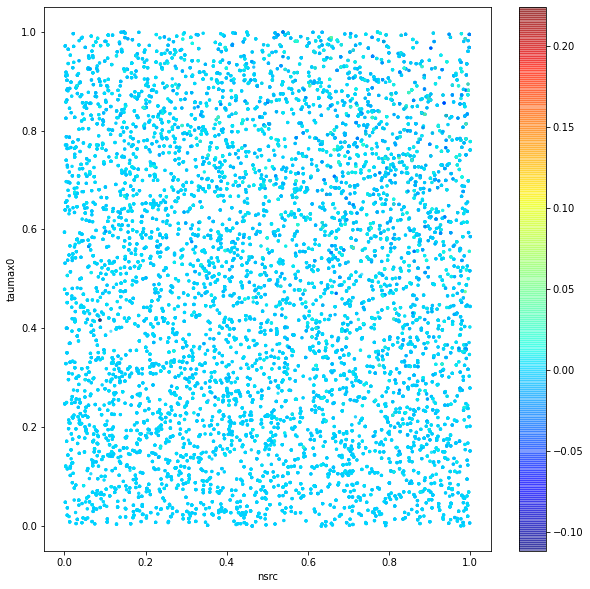

In [45]:
plt.figure(figsize=(10,10))
plt.scatter(params_normed[:, 0], params_normed[:, 1], s=5, c=mean_e, alpha=0.5, cmap='jet')
plt.colorbar()
plt.xlabel('nsrc')
plt.ylabel('taumax0')

Text(0, 0.5, 'ellipsoid z')

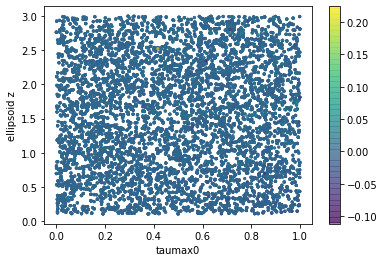

In [46]:
plt.figure()
plt.scatter(params_normed[:, 1], params_normed[:, 2], s=5, c=mean_e, alpha=0.5)
plt.colorbar()
plt.xlabel('taumax0')
plt.ylabel('ellipsoid z')

Text(0, 0.5, 'ellipsoid z')

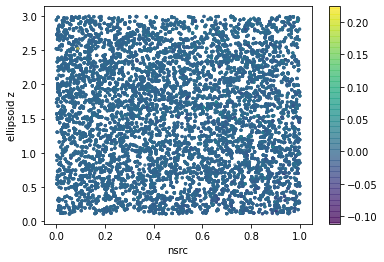

In [47]:
plt.figure()
plt.scatter(params_normed[:, 0], params_normed[:, 2], s=5, c=mean_e, alpha=0.5)
plt.colorbar()
plt.xlabel('nsrc')
plt.ylabel('ellipsoid z')

Text(0, 0.5, 'inclination')

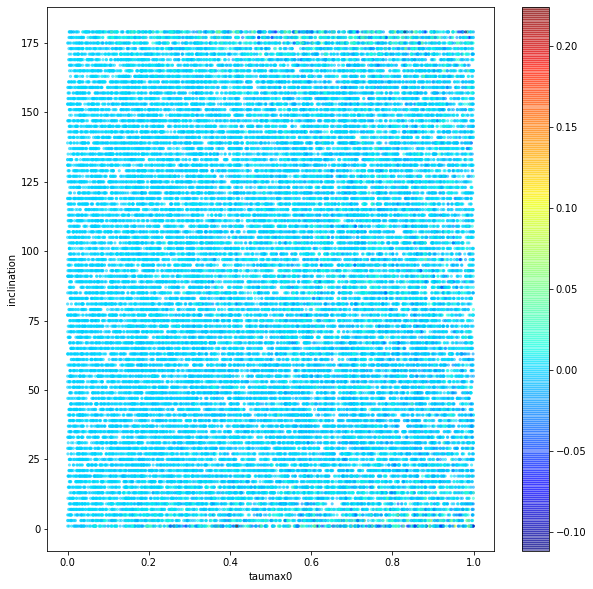

In [48]:
plt.figure(figsize=(10,10))
plt.scatter(params_normed[:, 1], np.rad2deg(np.arccos(params_normed[:, 3])), s=5, c=mean_e, alpha=0.5, cmap='jet')
plt.colorbar()
plt.xlabel('taumax0')
plt.ylabel('inclination')

Text(0, 0.5, 'max polarization')

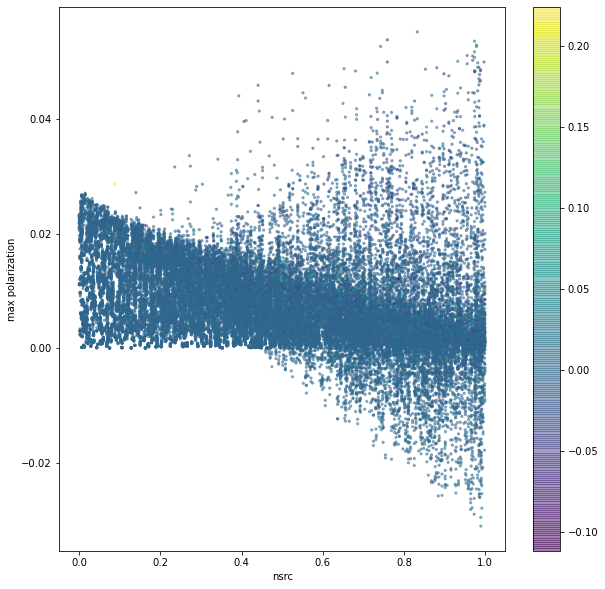

In [49]:
plt.figure(figsize=(10,10))
plt.scatter(params_normed[:, 0], y_test_normed.max(axis=1), s=5, c=mean_e, alpha=0.5)
plt.colorbar()
plt.xlabel('nsrc')
plt.ylabel('max polarization')

Text(0, 0.5, 'polarization')

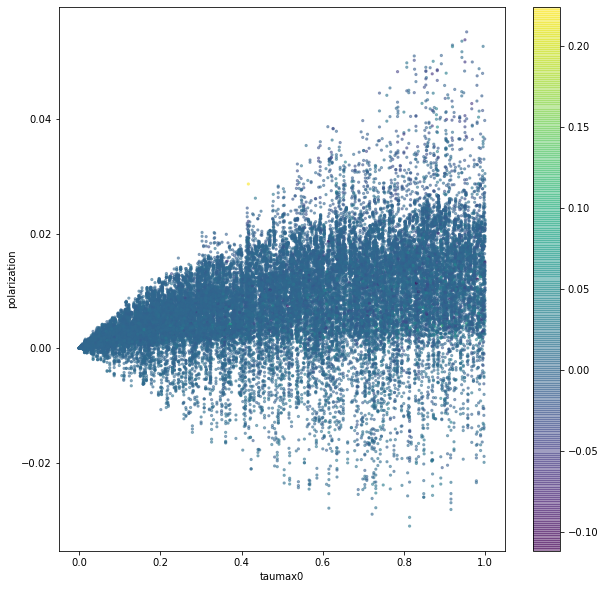

In [50]:
plt.figure(figsize=(10,10))
plt.scatter(params_normed[:, 1], y_test_normed.max(axis=1), s=5, c=mean_e, alpha=0.5)
plt.colorbar()
plt.xlabel('taumax0')
plt.ylabel('polarization')

Text(0, 0.5, 'polarization')

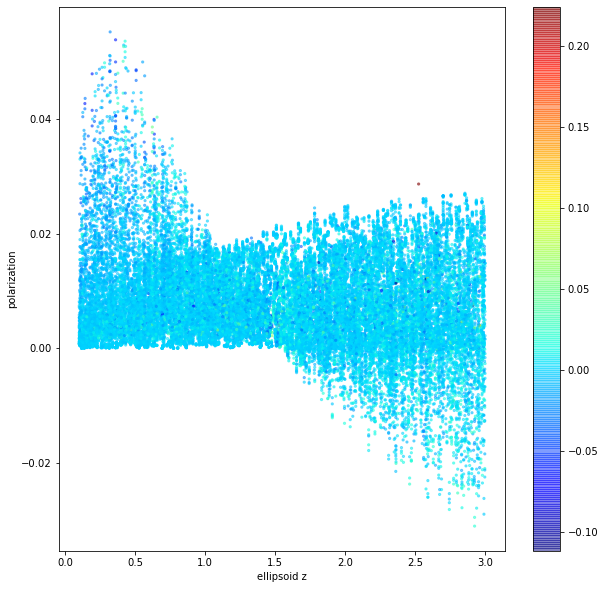

In [51]:
plt.figure(figsize=(10,10))
plt.scatter(params_normed[:, 2], y_test_normed.max(axis=1), s=5, c=mean_e, alpha=0.5, cmap='jet')
plt.colorbar()
plt.xlabel('ellipsoid z')
plt.ylabel('polarization')

Text(0, 0.5, 'polarization')

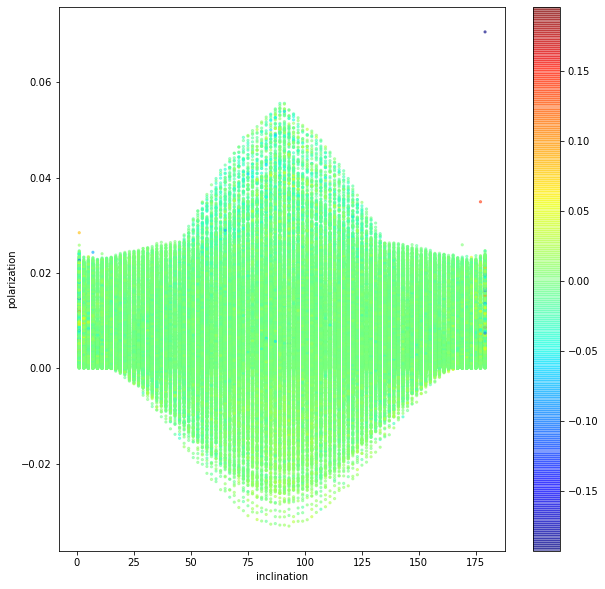

In [109]:
plt.figure(figsize=(10,10))
plt.scatter(np.rad2deg(np.arccos(params_normed[:, 3])), y_test_normed.max(axis=1), s=5, c=mean_e, alpha=0.5, cmap='jet')
plt.colorbar()
plt.xlabel('inclination')
plt.ylabel('polarization')